In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
import scipy.io

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
events_raw = scipy.io.loadmat(path + "/data/stripes.mat")
events_rel = events_raw["events"]
events = np.zeros(events_rel.shape)
events[:,0] = events_rel[:,3] * 10e-6
events[:,1:] = events_rel[:,:3]

events_raw = events

In [62]:
events_ref = flt.filter_refract(events_raw, 0.5)

In [63]:
start_time = 0.5
duration = 0.5
events_t = flt.filter_time(events_ref, start_time, start_time+duration)
events_t.shape

(6881, 4)

In [64]:
patch_center = (64, 64)
patch_size = 128
shape = (patch_size, patch_size)
events = flt.filter_patch(events_t, patch_center, patch_size)
events.shape

(6881, 4)

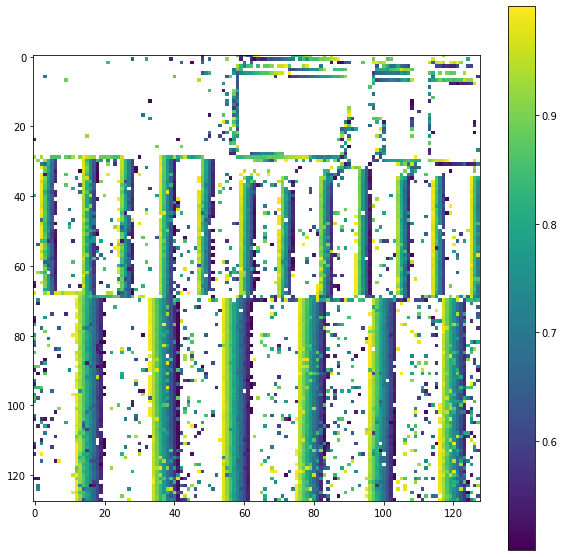

In [65]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

In [87]:
row = 2
last_time = np.full(shape, -1.0)
td_predictions = {}
predictions = {}
px_range_pred = 7
dist = 3
final_td = np.zeros(shape)
for e in events:
#     if e[2] != row:
#         continue
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1]-dist:
        continue
    if last_time[y, x+dist] == -1:
        continue
            
    time_difference = (last_time[y, x] - last_time[y, x+dist]) / dist
    #rint(time_difference)
    
    if (y, x) in td_predictions:
        mean_pred = np.mean(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 0.01:
            last_time[y, x] = -1.0
            continue
        if np.abs(mean_pred - time_difference) > 0.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            continue
        if e[0] > start_time + duration -0.1 and len(td_predictions[y, x]) > 3:
            final_td[y, x] = mean_pred
        
        td_predictions[y, x] = []
    
    for i in range(1, px_range_pred +1):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            y_p = y + k
            x_p = x - i
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or y_p < 0 or y_p >= shape[0]:
                continue

            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]
    

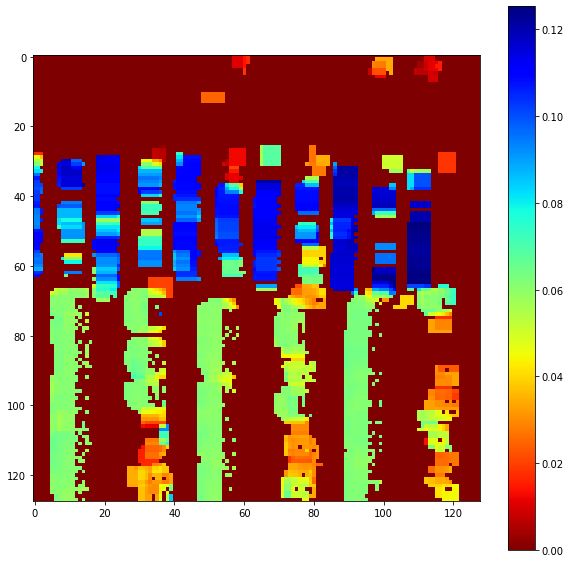

In [88]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 3)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r")
plt.colorbar(m)

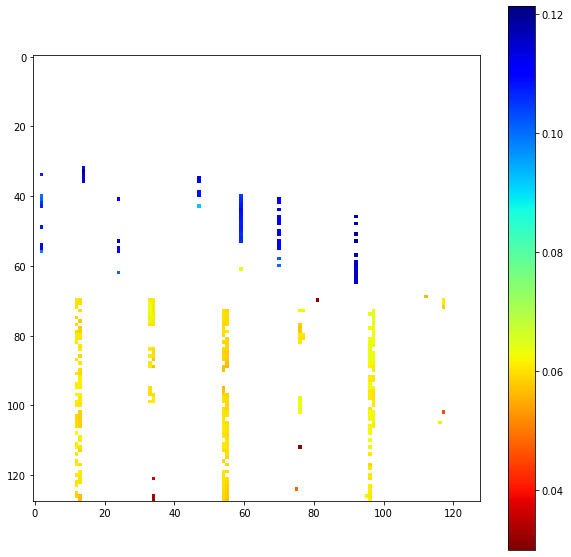

In [89]:
plt.figure(figsize=(10, 10))
final_td_m = np.ma.masked_where(final_td == 0, final_td)
m = plt.imshow(final_td_m, cmap="jet_r", interpolation="none")
plt.colorbar(m)